# Apply Attention to DateTranslation Datasets.
* Attention works prettye well!

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
input_date = [] # 変換前の日付データ
output_date = [] # 変換後の日付データ

file_path = 'data/date.txt'

# date.txtを1行ずつ読み込んで変換前と変換後に分割して、inputとoutputで分ける
with open(file_path, "r") as f:
    date_list = f.readlines()
    for date in date_list:
        date = date[:-1]
        input_date.append(date.split("_")[0])
        output_date.append("_" + date.split("_")[1])

# inputとoutputの系列の長さを取得
# すべて長さが同じなので、0番目の要素でlenを取ってます
input_len = len(input_date[0]) # 29
output_len = len(output_date[0]) # 10

# date.txtで登場するすべての文字にIDを割り当てる
char2id = {}
for input_chars, output_chars in zip(input_date, output_date):
    for c in input_chars:
        if not c in char2id:
            char2id[c] = len(char2id)
    for c in output_chars:
        if not c in char2id:
            char2id[c] = len(char2id)

input_data = [] # ID化された変換前日付データ
output_data = [] # ID化された変換後日付データ
for input_chars, output_chars in zip(input_date, output_date):
    input_data.append([char2id[c] for c in input_chars])
    output_data.append([char2id[c] for c in output_chars])

# 7:3でtrainとtestに分ける
train_x, test_x, train_y, test_y = train_test_split(input_data, output_data, train_size= 0.7)

# データをバッチ化するための関数を定義
def train2batch(input_data, output_data, batch_size=100):
    input_batch = []
    output_batch = []
    input_shuffle, output_shuffle = shuffle(input_data, output_data)
    for i in range(0, len(input_data), batch_size):
        input_batch.append(input_shuffle[i:i+batch_size])
        output_batch.append(output_shuffle[i:i+batch_size])
    return input_batch, output_batch

In [3]:
embedding_dim = 200
hidden_dim = 128
vocab_size = len(char2id)

BATCH_NUM = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

criterion = nn.CrossEntropyLoss()

cuda


# Encoder
* LSTM has cell-state, but GRU does not have cell-state.

In [4]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=char2id[" "])
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)

    def forward(self, sequence):
        embedding = self.word_embeddings(sequence)
        hs, h = self.gru(embedding)
        # GRU has no cell-state!
        return hs, h

# Attention-Decoder

In [5]:
class AttentionDecoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, batch_size, num_layers=1):
        super(AttentionDecoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=char2id[" "])
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        # hidden_dim * 2: concat GRU hidden dim and Attention context-vector.
        self.hidden2linear = nn.Linear(hidden_dim * 2, vocab_size)
        # dim=1 is input_time-sequence.
        self.softmax = nn.Softmax(dim=1) 

    def forward(self, sequence, hs, h):
        embedding = self.word_embeddings(sequence)
        output, state = self.gru(embedding, h)
        
        # Attention layer.
        # t_output format: [batch_size, emb_vec, output_time_seq]
        t_output = torch.transpose(output, 1, 2)
        
        # hs_format: [batch_size, input_time_seq, emb_vec]
        # s_format: [batch_size, input_time_seq, output_time_seq]
        s = torch.bmm(hs, t_output)
        
        # atteintion_weight.shape == s.shape
        attention_weight = self.softmax(s)
        
        # c_format: [batch_size, 1, emb_vec]
        c = torch.zeros(self.batch_size, 1, self.hidden_dim, device=device)
        
        for i in range(attention_weight.size()[2]):
            # unsq_weight: [batch_size, input_time_seq, 1]
            unsq_weight = attention_weight[:, :, i].unsqueeze(2)
            # hs_format: [batch_size, input_time_seq, emb_vec]
            # weited_hs_format: [batch_size, input_time_seq, emb_vec]
            weighted_hs = hs * unsq_weight
            # weight_sum_format: [batch_size, 1, emb_vec]
            weight_sum = torch.sum(weighted_hs, axis=1).unsqueeze(1)
            # c_format: [batch_size, i, emb_vec]
            c = torch.cat([c, weight_sum], dim=1)
            
        # rm zero elm.
        c = c[:, 1:, :]
        #print("output.shape, c.shape: ", output.shape, c.shape)
        output = torch.cat([output, c], dim=2)
        output = self.hidden2linear(output)

        return output, state, attention_weight

In [6]:
def train(EPOCH_NUM=100, lr=0.001):
    all_losses = []
    print("training...")
    
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.001)
    
    for epoch in range(1, EPOCH_NUM + 1):
        epoch_loss = 0

        input_batch, output_batch = train2batch(train_x, train_y, batch_size=BATCH_NUM)

        for i in range(len(input_batch)):
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()

            input_ts = torch.tensor(input_batch[i], device=device)
            output_ts = torch.tensor(output_batch[i], device=device)

            hs, h = encoder(input_ts)

            # last-data can not be next-input.
            training_source = output_ts[:, :-1]
            # start symbol can not ba data to train.
            training_data = output_ts[:, 1:]

            loss = 0

            decoder_output, _, attention_weight = decoder(training_source, hs, h)

            for j in range(decoder_output.size()[1]):
                loss += criterion(decoder_output[:, j, :], training_data[:, j])

            epoch_loss += loss.item()
            loss.backward()

            encoder_optimizer.step()
            decoder_optimizer.step()

        print("Epoch %d: %.2f" % (epoch, epoch_loss))
        all_losses.append(epoch_loss)
        if epoch_loss < 0.1: break
    print("Done")
    
    return all_losses

In [7]:
encoder = Encoder(vocab_size, embedding_dim, hidden_dim, num_layers=1).to(device)
decoder = AttentionDecoder(vocab_size, embedding_dim, hidden_dim, batch_size=BATCH_NUM).to(device)

# Training

In [8]:
all_losses = train(EPOCH_NUM=100, lr=0.001)

training...
Epoch 1: 1528.55
Epoch 2: 36.01
Epoch 3: 15.01
Epoch 4: 6.91
Epoch 5: 17.26
Epoch 6: 6.02
Epoch 7: 2.16
Epoch 8: 1.32
Epoch 9: 0.92
Epoch 10: 0.68
Epoch 11: 0.52
Epoch 12: 0.40
Epoch 13: 0.32
Epoch 14: 0.26
Epoch 15: 0.21
Epoch 16: 0.17
Epoch 17: 0.14
Epoch 18: 0.11
Epoch 19: 0.09
Done


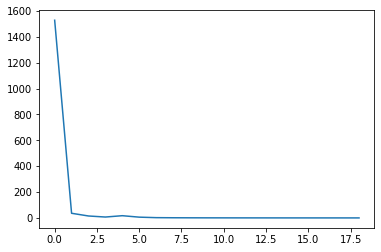

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(all_losses)

# Prediction

In [10]:
def get_max_index(decoder_output):  
    results = []
    for h in decoder_output:
        results.append(torch.argmax(h))
        
    results = torch.tensor(results, device=device).view(BATCH_NUM, 1)
    return results

In [12]:
import pandas as pd

test_input_batch, test_output_batch = train2batch(test_x, test_y)
input_tensor = torch.tensor(test_input_batch, device=device)

predicts = []
for i in range(len(test_input_batch)):
    with torch.no_grad(): 
        hs, h = encoder(input_tensor[i])
        decoder_hidden = h

        # Add start symbol.
        start_char_batch = [[char2id["_"]] for _ in range(BATCH_NUM)]
        decoder_input_tensor = torch.tensor(start_char_batch, device=device)
        # store prediction.
        batch_tmp = torch.zeros(100,1, dtype=torch.long, device=device)

    for _ in range(output_len - 1):
            decoder_output, decoder_hidden, _ = decoder(decoder_input_tensor, hs, decoder_hidden)
            # output(predicted character) will be next input.
            decoder_input_tensor = get_max_index(decoder_output.squeeze())
            batch_tmp = torch.cat([batch_tmp, decoder_input_tensor], dim=1)
            # remove head element.
            
    predicts.append(batch_tmp[:,1:])

id2char = {}
for k, v in char2id.items():
    id2char[v] = k

row = []
for i in range(len(test_input_batch)):
    batch_input = test_input_batch[i]
    batch_output = test_output_batch[i]
    batch_predict = predicts[i]
    for inp, output, predict in zip(batch_input, batch_output, batch_predict):
        x = [id2char[idx] for idx in inp]
        y = [id2char[idx] for idx in output[1:]]
        p = [id2char[idx.item()] for idx in predict]

        x_str = "".join(x)
        y_str = "".join(y)
        p_str = "".join(p)

        judge = "O" if y_str == p_str else "X"
        row.append([x_str, y_str, p_str, judge])
        
predict_df = pd.DataFrame(row, columns=["input", "answer", "predict", "judge"])
predict_df.head()

,input,answer,predict,judge
0,8/28/73,1973-08-28,1973-08-28,O
1,"Mar 1, 1976",1976-03-01,1976-03-01,O
2,1/8/98,1998-01-08,1998-01-08,O
3,"JULY 4, 1994",1994-07-04,1994-07-04,O
4,9/25/93,1993-09-25,1993-09-25,O


In [13]:
print(len(predict_df.query('judge == "O"')) / len(predict_df))
predict_df.query('judge == "X"').head(10)

1.0


,input,answer,predict,judge
